In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import math
import os
from matplotlib.patches import Rectangle
from matplotlib import cm
#from scipy.stats import qmc
import pandas as pd
from IPython.display import display, Latex
import ast

2024-05-16 08:48:17.270998: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 08:48:17.365893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 08:48:18.473927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


2024-05-16 08:48:20.157669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 08:48:20.229457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 08:48:20.229511: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
#torch.manual_seed(42)
#np.random.seed(42)

In [4]:
tf.keras.backend.set_floatx("float64")

In [5]:
def record_and_update_performance(value, filename):
    existing_times = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                line = line.strip()
                if line.startswith('[') and line.endswith(']'):
                    try:
                        numbers = ast.literal_eval(line)
                        if isinstance(numbers, list):
                            existing_times.extend(numbers)
                    except (SyntaxError, ValueError):
                        print(f"Skipping invalid list format: {line}")
                elif line.replace('.', '', 1).isdigit():
                    try:
                        existing_times.append(float(line))
                    except ValueError:
                        print(f"Skipping invalid float format: {line}")
                else:
                    print(f"Skipping non-numeric line: {line}")
    except FileNotFoundError:
        print("No existing file found. A new file will be created.")

    existing_times.append(value)
    
    avg = np.mean(existing_times)
    min_val = np.min(existing_times)
    max_val = np.max(existing_times)
    
    deviation_min = avg - min_val
    deviation_max = max_val - avg
    
    with open(filename, 'w') as file:
        for time_record in existing_times:
            file.write(f"{time_record}\n")
        minutes_avg = int(avg // 60)
        seconds_avg = int(avg % 60)
        text = f"Average among {len(existing_times)} trainings: {minutes_avg:.2f}min {seconds_avg}s, (Deviation from Min: {deviation_min:.2f}s, Deviation from Max: {deviation_max:.2f}s), STD: {np.std(existing_times)}\n"
        file.write(text)
        print(text)
    
    print("Updated data recorded successfully.")


In [6]:
class Laplace2DPINN():
    def __init__(self, input_shape=1, out_shape=1, layers=[10, 10, 10], activation='tanh', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), alpha=1):
        super(Laplace2DPINN, self).__init__()
        self.optimizer = optimizer
        self.model = self.build(input_shape, out_shape, layers, activation)
        self.alpha = alpha

    def build(self, input_shape, output_shape, layers, activation):
        input_layer = tf.keras.layers.Input(shape=(input_shape,))
        kernel_initializer = tf.keras.initializers.GlorotNormal()# seed=177013

        hidden = [tf.keras.layers.Dense(layers[0], activation=activation)(input_layer)]
        for i in range(1, len(layers)):
            new_layer = tf.keras.layers.Dense(
                    layers[i],
                    activation=activation,
                    activity_regularizer=None,
                    kernel_initializer=kernel_initializer
                )(hidden[-1])
            hidden.append(new_layer)

        output_layer = tf.keras.layers.Dense(output_shape, activation=None)(hidden[-1])

        name = f"DNN-{len(layers)}"
        model = tf.keras.Model(input_layer, output_layer, name=name)
        model.summary()
    
        return model


    def forward(self, x1_x2):
        x1_x2 = tf.convert_to_tensor(x1_x2, dtype=tf.float64)
        
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x1_x2)
            with tf.GradientTape() as tape:
                tape.watch(x1_x2)
                u = self.model(x1_x2)
            grads = tape.gradient(u, x1_x2)
            u_x1, u_x2 = grads[:, 0], grads[:, 1]
        grads2 = tape2.gradient(u_x1, x1_x2)
        u_x1_x1 = grads2[:, 0]

        grads3 = tape2.gradient(u_x2, x1_x2)
        u_x2_x2 = grads3[:, 1]

        del tape2

        return u, u_x1, u_x2, u_x1_x1, u_x2_x2

    @tf.function
    def dirichlet_condition(self, x1_bc, x2_bc, u_bc):
        x_t = tf.concat([x1_bc, x2_bc], axis=1)
        u = self.model(x_t)
        return 10 * tf.reduce_mean(tf.square(u - u_bc))

    @tf.function
    def neuman_condition(self, x1_bc_neuman, x2_bc_neuman):
        x1_left = x1_bc_neuman[:len(x2_bc_neuman)//2]
        x2_left = x2_bc_neuman[:len(x2_bc_neuman)//2]
        x1_right = x1_bc_neuman[len(x2_bc_neuman)//2:]
        x2_right = x2_bc_neuman[len(x2_bc_neuman)//2:]
        x1_x2_left = tf.concat([x1_left, x2_left], axis=1)
        x1_x2_right = tf.concat([x1_right, x2_right], axis=1)

        u_left = self.model(x1_x2_left)
        u_x1_left = tf.gradients(u_left, x1_left)[0]
        u_right = self.model(x1_x2_right)
        u_x1_right = tf.gradients(u_right, x1_right)[0]

        return tf.reduce_mean(tf.square(-u_x1_left)) + 2 * tf.reduce_mean(tf.square(u_x1_right - self.alpha * u_right))

    @tf.function
    def loss_fn(self, x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman):
        x_t = tf.concat([x1_in, x2_in], axis=1)
        u0 = self.model(x_t)
        u_x = tf.gradients(u0, x1_in)[0]
        u_y = tf.gradients(u0, x2_in)[0]
        u_xx = tf.gradients(u_x, x1_in)[0]
        u_yy = tf.gradients(u_y, x2_in)[0]
        laplace_eq = u_xx + u_yy
        bc_dirichlet = self.dirichlet_condition(x1_bc, x2_bc, u_bc)
        bc_neuman = self.neuman_condition(x1_bc_neuman, x2_bc_neuman)

        return tf.reduce_mean(tf.square(laplace_eq)) + (bc_dirichlet + bc_neuman)
    
    def save_model(self, epoch, base_path='model_2d_robin_checkpoints'):
        if not os.path.exists(base_path):
            os.makedirs(base_path)
        model_path = os.path.join(base_path, f'model_2d_robin_at_epoch_{epoch}.h5')
        self.model.save(model_path)
        print(f"Model saved at {model_path}")

    def train(self, loss_threshold, x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman):
        loss_array = []
        start_time = time.time()
        best_epoch_times = math.inf
        loss = tf.constant(float('inf'))
        epoch = 0
        try:
            while loss.numpy() > loss_threshold:
                with tf.GradientTape() as tape:
                    loss = self.loss_fn(x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman)
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                elapsed_time = time.time() - start_time
                if (best_epoch_times > elapsed_time):
                    best_epoch_times = elapsed_time
                minutes = int(elapsed_time // 60)
                seconds = int(elapsed_time % 60)
                loss_array.append(loss)
                if epoch % 100 == 0:
                    print(f'Epoch: {epoch}, Loss: {loss.numpy()}, time: {"%d minutes and %d seconds" % (minutes, seconds)}')
                if epoch % 1000 == 0 and epoch != 0:
                    self.save_model(epoch)
                epoch += 1
        except KeyboardInterrupt:
            print("Training stopped manually")

        elapsed_time = time.time() - start_time
        minutes = int(elapsed_time // 60)
        seconds = int(elapsed_time % 60)
        print("Training took %d minutes and %d seconds" % (minutes, seconds))
        print(f"Last epoch: {epoch}, loss: {loss.numpy()}")
        print(f"Best epoch: {np.argmin(loss_array)}, loss: {min(loss_array)}, time: {best_epoch_times}")
        record_and_update_performance(elapsed_time, 'performance_data_2d_laplace.txt')

        plt.plot(loss_array)
        plt.xlabel('Епоха')
        plt.ylabel('Втрати')
        plt.grid()
        plt.title('Значення втрат')
        plt.savefig("2d_laplace_robin_equation_training.png")
        plt.show(block=False)

        start_epoch = 1000
        end_epoch = 3000

        end_epoch = min(end_epoch, len(loss_array) - 1)

        plt.plot(range(start_epoch, end_epoch + 1), loss_array[start_epoch:end_epoch + 1])
        plt.xlabel('Епоха')
        plt.ylabel('Втрати')
        plt.grid()
        plt.title('Значення втрат від 1000 до 3000 епохи')
        plt.show(block=False)

2024-05-16 08:48:20.306220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 08:48:20.306390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 08:48:20.306439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 08:48:20.443700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 08:48:20.444036: I tensorflow/compile

In [7]:
N_of_train_points_for_one_axis_2D = 11
N_of_test_points_2D = 1000
N_of_fem_points_2D = 10
L_x1 = 0.0
R_x1 = 1.0
L_x2 = 0.0
R_x2 = 1.0
alpha = 1
Dirichlet_up_2D = 1.0
Dirichlet_down_2D = 0.0
loss_threshold_2D = 1e-3
Layers_2D = [10, 10, 10]
Learning_rate_2D = 1e-2
Optimizer_2D = tf.keras.optimizers.Adam(learning_rate=Learning_rate_2D)

In [8]:
model_2D = Laplace2DPINN(2, 1, Layers_2D, 'tanh', Optimizer_2D, alpha)
# tf.keras.utils.plot_model(model_2D.model, to_file='model_plot.png', show_shapes=True, 
#                           show_layer_names=True, show_dtype=True, 
#                           show_layer_activations=True)

Model: "DNN-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


/home/user/miniconda3/envs/fenicsproject/lib/python3.8/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


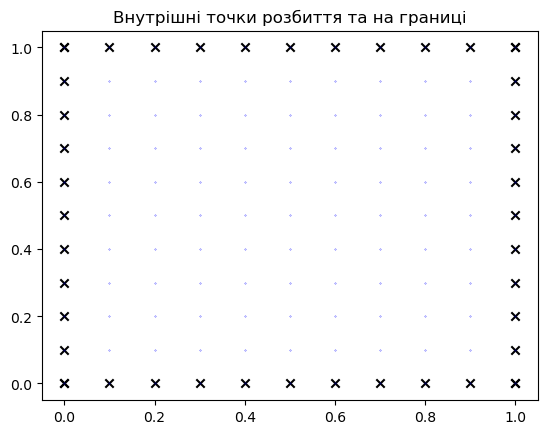

In [9]:
n_bc = 4
n_bc_dirichlet = 2
n_bc_neuman = 2
n_data_per_bc = N_of_train_points_for_one_axis_2D
Nc = N_of_train_points_for_one_axis_2D * N_of_train_points_for_one_axis_2D

#engine = qmc.LatinHypercube(d=1)
data_dirichlet = np.zeros([2, n_data_per_bc, 3])
data_neuman = np.zeros([2, n_data_per_bc, 3])

for i, j in zip(range(n_bc_dirichlet), [L_x2, R_x2]):
    #points = qmc.scale(engine.random(n=n_data_per_bc), [L_x1], [R_x1])[:, 0]
    points = np.linspace(L_x1, R_x1, n_data_per_bc)
    data_dirichlet[i, :, 0] = points
    data_dirichlet[i, :, 1] = j

for i, j in zip(range(n_bc_neuman), [L_x1, R_x1]):
    #epoints = qmc.scale(ngine.random(n=n_data_per_bc), [L_x2], [R_x2])[:, 0]
    points = np.linspace(L_x2, R_x2, n_data_per_bc)
    data_neuman[i, :, 0] = j
    data_neuman[i, :, 1] = points

data_dirichlet[0, :, 2] = 0.0
data_dirichlet[1, :, 2] = 1.0

data_dirichlet = data_dirichlet.reshape(n_data_per_bc * n_bc_dirichlet, 3)
data_neuman = data_neuman.reshape(n_data_per_bc * n_bc_neuman, 3)

x1_bc, x2_bc, u_bc = map(lambda x: np.expand_dims(x, axis=1), 
                    [data_dirichlet[:, 0], data_dirichlet[:, 1], data_dirichlet[:, 2]])

x1_bc_neuman, x2_bc_neuman = map(lambda x: np.expand_dims(x, axis=1), 
                    [data_neuman[:, 0], data_neuman[:, 1]])

# engine = qmc.LatinHypercube(d=2)
# colloc = engine.random(n=Nc)

X_1, X_2 = np.meshgrid(np.linspace(0, 1, N_of_train_points_for_one_axis_2D), np.linspace(0, 1, N_of_train_points_for_one_axis_2D))
colloc = np.vstack([X_1.ravel(), X_2.ravel()]).T

colloc = np.column_stack((L_x1 + colloc[:,0] * (R_x1 - L_x1), L_x2 + colloc[:,1] * (R_x2 - L_x2)))

x1_in, x2_in = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

plt.title("Внутрішні точки розбиття та на границі")
plt.scatter(data_dirichlet[:, 0], data_dirichlet[:, 1], marker="x", c="k", label="BDP")
plt.scatter(data_neuman[:, 0], data_neuman[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="b", label="CP")
plt.show()

x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman = map(
    lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
    [x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman]
)

2024-05-16 08:48:22.143821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_11' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_11}}]]
2024-05-16 08:48:22.302479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_1_grad/StatefulPartitionedCall_1_4' with dtype int32 and shape [2]
	 [[{{node gradients/StatefulPartitionedCall_1_grad/StatefulPartitionedCall_1_4}}]]
2024-05-16 08:48:22.302592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start a

Epoch: 0, Loss: 9.5535423342411, time: 0 minutes and 2 seconds
Epoch: 100, Loss: 0.3986659886691666, time: 0 minutes and 4 seconds
Epoch: 200, Loss: 0.20651429621810719, time: 0 minutes and 5 seconds
Epoch: 300, Loss: 0.11407064292012181, time: 0 minutes and 7 seconds
Epoch: 400, Loss: 0.06604610856477117, time: 0 minutes and 8 seconds
Epoch: 500, Loss: 0.03429381807691573, time: 0 minutes and 10 seconds
Epoch: 600, Loss: 0.02009164873318764, time: 0 minutes and 11 seconds
Epoch: 700, Loss: 0.013682643003308563, time: 0 minutes and 13 seconds
Epoch: 800, Loss: 0.011361104364411038, time: 0 minutes and 14 seconds
Epoch: 900, Loss: 0.010286787165537976, time: 0 minutes and 16 seconds
Epoch: 1000, Loss: 0.009513612008826052, time: 0 minutes and 18 seconds
Model saved at model_2d_robin_checkpoints/model_2d_robin_at_epoch_1000.h5
Epoch: 1100, Loss: 0.008856103742735226, time: 0 minutes and 19 seconds
Epoch: 1200, Loss: 0.008352357307813196, time: 0 minutes and 21 seconds
Epoch: 1300, Loss: 

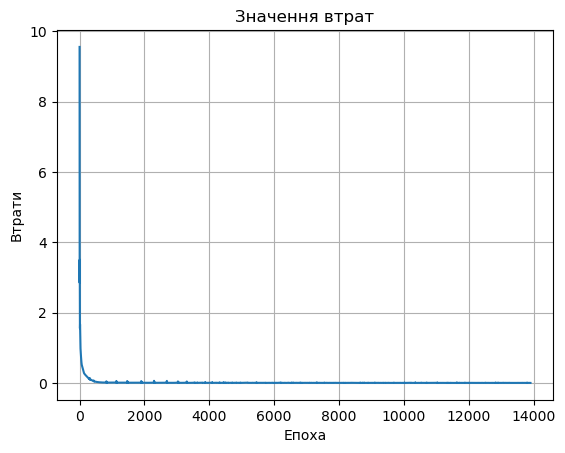

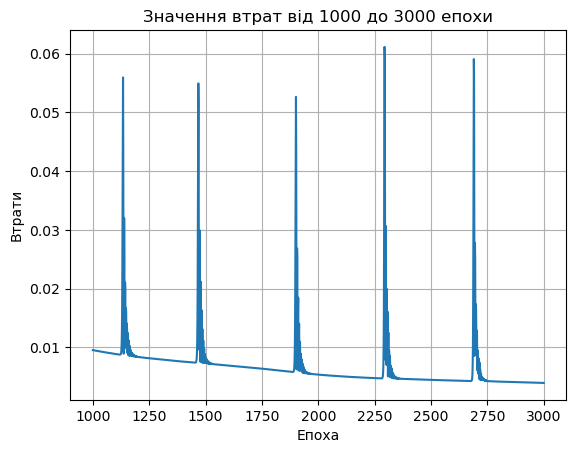

In [10]:
model_2D.train(loss_threshold_2D, x1_in, x2_in, x1_bc, x2_bc, u_bc, x1_bc_neuman, x2_bc_neuman)

In [11]:
x1_test = np.linspace(L_x1, R_x1, N_of_test_points_2D)[:, np.newaxis]
x2_test = np.linspace(L_x2, R_x2, N_of_test_points_2D)[:, np.newaxis]
x1_mesh, x2_mesh = np.meshgrid(x1_test, x2_test)
x1x2_test = np.hstack((x1_mesh.flatten()[:, np.newaxis], x2_mesh.flatten()[:, np.newaxis]))

u_pinn = model_2D.model(x1x2_test).numpy().reshape(x1_test.shape[0], x2_test.shape[0])

In [23]:
from tensorflow.keras.models import load_model
model_path = 'model_2d_robin_checkpoints/model_2d_robin_at_epoch_3000.h5'
model_2D_3000 = load_model(model_path)
u_pinn_values_3000 = model_2D_3000(x1x2_test).numpy().reshape(x1_test.shape[0], x2_test.shape[0])

/home/user/miniconda3/envs/fenicsproject/lib/python3.8/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [24]:
model_path = 'model_2d_robin_checkpoints/model_2d_robin_at_epoch_6000.h5'
model_2D_6000 = load_model(model_path)
u_pinn_values_6000 = model_2D_6000(x1x2_test).numpy().reshape(x1_test.shape[0], x2_test.shape[0])

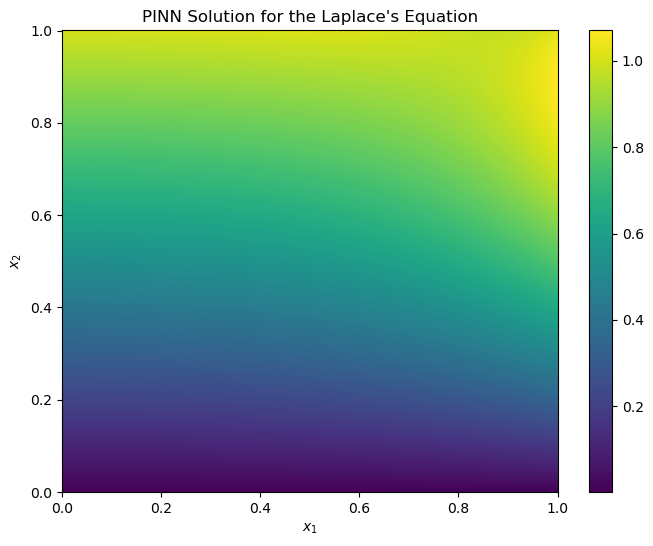

In [14]:
plt.figure(figsize=(8, 6))
plt.pcolor(x1_mesh, x2_mesh, u_pinn, cmap='viridis')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('PINN Solution for the Laplace\'s Equation')
plt.savefig("2d_laplace_robin_equation_exact_solution_heatmap.png")
plt.show(block=False)

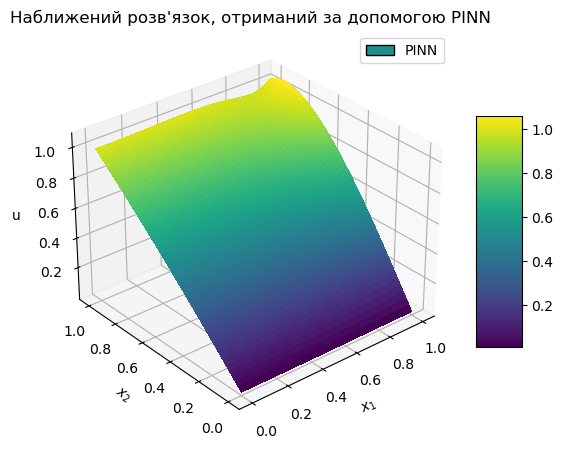

In [15]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x1_mesh, x2_mesh, u_pinn, cmap='viridis', linewidth=0, antialiased=False, label='PINN Solution 2D', zorder=0)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('u')
ax.set_title('Наближений розв\'язок, отриманий за допомогою PINN')
color_for_legend = cm.viridis(0.5)
proxy = Rectangle((0, 0), 1, 1, fc=color_for_legend, edgecolor="k")
ax.legend([proxy], ['PINN'])
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=30, azim=-130)
plt.subplots_adjust(left=0.4) 
plt.savefig("2d_laplace_robin_equation_approx_solution.png")
plt.show()

bash: /home/user/miniconda3/envs/fenicsproject/lib/libtinfo.so.6: no version information available (required by bash)
bash: /home/user/miniconda3/envs/fenicsproject/lib/libtinfo.so.6: no version information available (required by bash)


Solving linear variational problem.


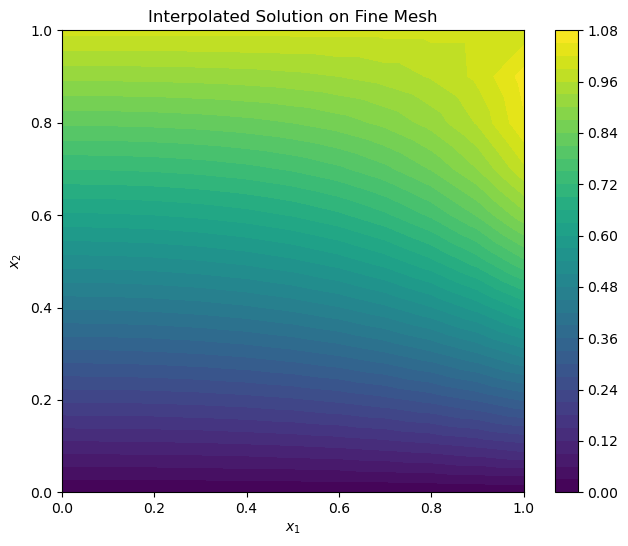

In [16]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

def solve_with_fem(N_coarse, N_fine):
    coarse_mesh = UnitSquareMesh(N_coarse, N_coarse)
    V_coarse = FunctionSpace(coarse_mesh, 'P', 1)

    u_top = Constant(1.0)
    u_bottom = Constant(0.0)

    def boundary_top(x, on_boundary):
        return on_boundary and near(x[1], 1)

    def boundary_bottom(x, on_boundary):
        return on_boundary and near(x[1], 0)

    bc_top = DirichletBC(V_coarse, u_top, boundary_top)
    bc_bottom = DirichletBC(V_coarse, u_bottom, boundary_bottom)
    bcs = [bc_top, bc_bottom]

    u = TrialFunction(V_coarse)
    v = TestFunction(V_coarse)
    f = Constant(0)
    a = dot(grad(u), grad(v))*dx
    L = f*v*dx

    class RightBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 1)

    right_boundary = RightBoundary()
    boundary_markers = MeshFunction('size_t', coarse_mesh, coarse_mesh.topology().dim()-1, 0)
    right_boundary.mark(boundary_markers, 1)
    ds = Measure('ds', domain=coarse_mesh, subdomain_data=boundary_markers)
    a += Constant(-alpha)*u*v*ds(1)
    L += Constant(0)*v*ds(1)

    u = Function(V_coarse)
    solve(a == L, u, bcs)

    fine_mesh = UnitSquareMesh(N_fine, N_fine)
    V_fine = FunctionSpace(fine_mesh, 'P', 1)
    u_fine = interpolate(u, V_fine)
    u_fem = u_fine.compute_vertex_values(fine_mesh).reshape((N_fine+1, N_fine+1))

    return fine_mesh, u_fine, u_fem


fine_mesh, u_fine, u_fem = solve_with_fem(N_of_fem_points_2D, N_of_test_points_2D-1)

plt.figure(figsize=(8, 6))
c = plot(u_fine)
plt.colorbar(c)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Interpolated Solution on Fine Mesh')
plt.show()

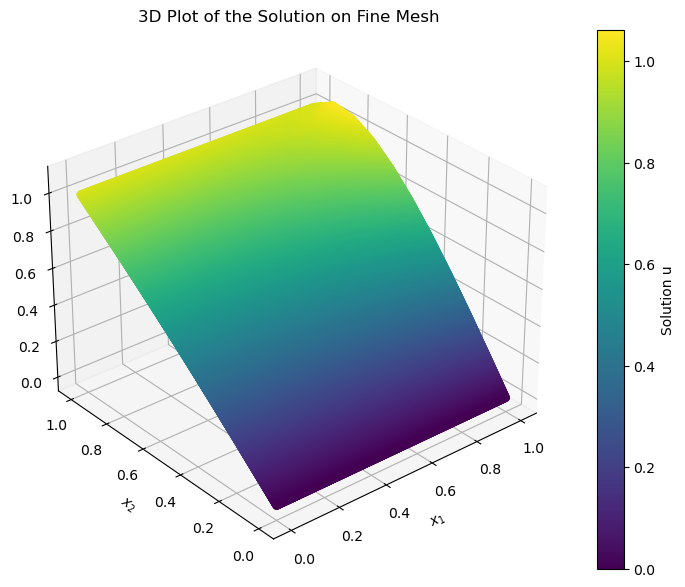

In [17]:
x_1_fine_mesh = fine_mesh.coordinates()[:, 0]
x_2_fine_mesh = fine_mesh.coordinates()[:, 1]
u_fine_mesh = u_fem.flatten()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_1_fine_mesh, x_2_fine_mesh, u_fine_mesh, c=u_fine_mesh, cmap='viridis')
fig.colorbar(scatter, ax=ax, label='Solution u')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('u')
ax.set_title('3D Plot of the Solution on Fine Mesh')
ax.view_init(elev=30, azim=-130)
plt.show()

In [18]:
def calculate_max_relative_error(u_pred, u_exact):
    u_pred_flat = u_pred.flatten()
    u_exact_flat = u_exact.flatten()
    return 100 * np.linalg.norm(u_exact_flat - u_pred_flat, np.inf) / np.linalg.norm(u_exact_flat, np.inf)

In [19]:
def relative_l2_norm_error(u_pred, u_true):
    u_pred_flat = u_pred.flatten()
    u_exact_flat = u_true.flatten()
    error_norm = np.linalg.norm(u_exact_flat - u_pred_flat)
    true_norm = np.linalg.norm(u_exact_flat)
    return 100 * error_norm / true_norm

In [20]:
def compute_errors(u_pinn, u_fem):
    mse_error = np.mean((u_fem - u_pinn)**2)
    print(f"Mean Squared Error (PINN and FEM): {mse_error:.3}")
    relative_error = calculate_max_relative_error(u_fem, u_pinn)
    display(Latex(f"Relative $l^{{\\infty}}$ error (PINN and FEM): {relative_error:.3}%"))
    relative_l2_error = relative_l2_norm_error(u_fem, u_pinn)
    display(Latex(f"Relative $l^{2}$ error (PINN and FEM): {relative_l2_error:.3}%"))

In [25]:
compute_errors(u_pinn, u_fem)

Mean Squared Error (PINN and FEM): 6.86e-06


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [26]:
compute_errors(u_pinn_values_3000, u_fem)

Mean Squared Error (PINN and FEM): 2.62e-05


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [41]:
compute_errors(u_pinn_values_6000, u_fem)

Mean Squared Error (PINN and FEM): 5.12e-05


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [27]:
fine_mesh_10, u_fine_10, u_fem_10 = solve_with_fem(10, N_of_test_points_2D-1)
fine_mesh_20, u_fine_20, u_fem_20 = solve_with_fem(20, N_of_test_points_2D-1)
#fine_mesh_50, u_fine_50, u_fem_50 = solve_with_fem(50, N_of_test_points_2D-1)
#fine_mesh_100, u_fine_100, u_fem_100 = solve_with_fem(100, N_of_test_points_2D-1)

x1_positions = np.linspace(L_x1, R_x1, N_of_test_points_2D)
x2_positions = np.linspace(L_x2, R_x2, N_of_test_points_2D)

Solving linear variational problem.
Solving linear variational problem.


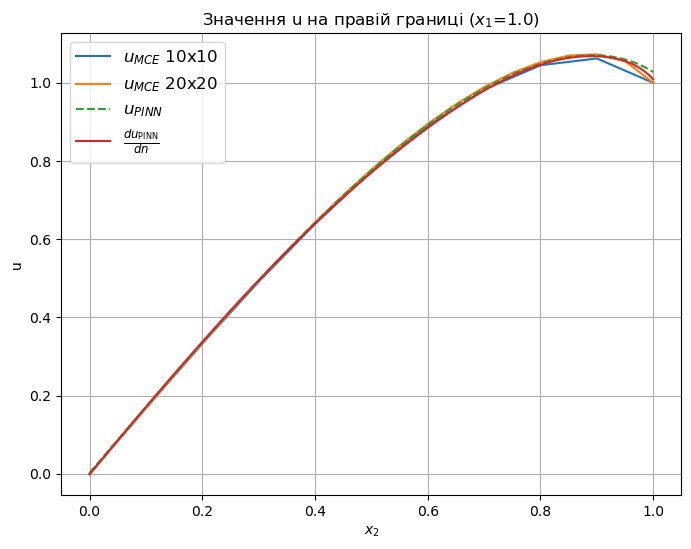

In [28]:
right_index = -1
right_boundary_fem_values_10 = u_fem_10[:, right_index]
right_boundary_fem_values_20 = u_fem_20[:, right_index]
#right_boundary_fem_values_50 = u_fem_50[:, right_index]
right_boundary_pinn_values = u_pinn[:, right_index]

dx = (R_x2 - L_x2) / (N_of_test_points_2D - 1)
du_dn_right_boundary = (u_pinn[:, -1] - u_pinn[:, -2]) / dx
x_2_values = np.linspace(L_x2, R_x2, N_of_test_points_2D)

plt.figure(figsize=(8, 6))
plt.plot(x2_positions, right_boundary_fem_values_10, label='$u_{МСЕ}$ 10x10')
plt.plot(x2_positions, right_boundary_fem_values_20, label='$u_{МСЕ}$ 20x20')
#plt.plot(x2_positions, right_boundary_fem_values_50, label='$u_{МСЕ}$ 50x50')
plt.plot(x2_positions, right_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.plot(x_2_values, du_dn_right_boundary, label=r'$\frac{du_{\mathrm{PINN}}}{dn}$')
plt.xlabel('$x_2$')
plt.ylabel('u')
plt.title(f'Значення u на правій границі ($x_1$={x1_positions[right_index]})')
plt.legend()
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

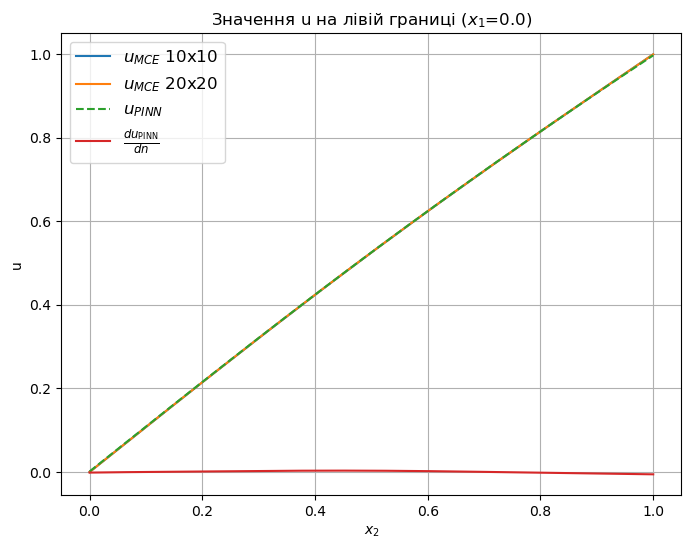

In [29]:
left_index = 0
left_boundary_fem_values_10 = u_fem_10[:, left_index]
left_boundary_fem_values_20 = u_fem_20[:, left_index]
#left_boundary_fem_values_50 = u_fem_50[:, left_index]
left_boundary_pinn_values = u_pinn[:, left_index]

dx = (R_x2 - L_x2) / (N_of_test_points_2D - 1)
du_dn_left_boundary = (u_pinn[:, 1] - u_pinn[:, 0]) / dx
x_2_values = np.linspace(L_x2, R_x2, N_of_test_points_2D)

plt.figure(figsize=(8, 6))
plt.plot(x2_positions, left_boundary_fem_values_10, label='$u_{МСЕ}$ 10x10')
plt.plot(x2_positions, left_boundary_fem_values_20, label='$u_{МСЕ}$ 20x20')
#plt.plot(x2_positions, left_boundary_fem_values_50, label='$u_{МСЕ}$ 50x50')
plt.plot(x2_positions, left_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.plot(x_2_values, du_dn_left_boundary, label=r'$\frac{du_{\mathrm{PINN}}}{dn}$')
plt.xlabel('$x_2$')
plt.ylabel('u')
plt.title(f'Значення u на лівій границі ($x_1$={x1_positions[left_index]})')
plt.legend()
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

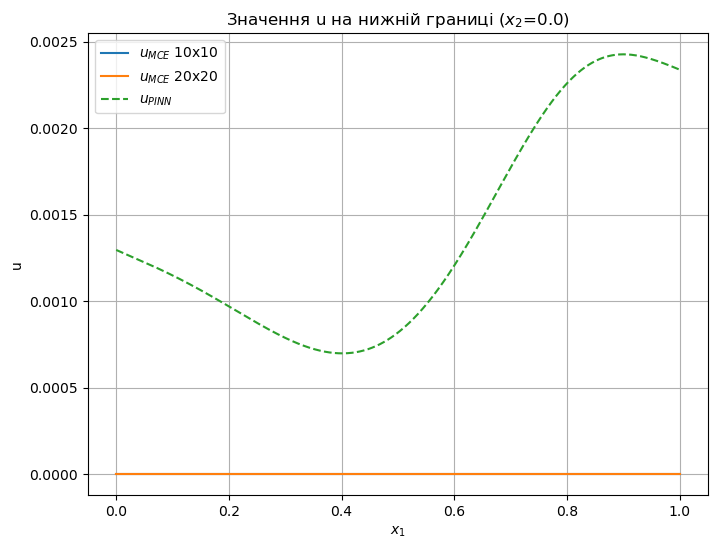

In [30]:
bottom_index = 0
bottom_boundary_fem_values_10 = u_fem_10[bottom_index, :]
bottom_boundary_fem_values_20 = u_fem_20[bottom_index, :]
#bottom_boundary_fem_values_50 = u_fem_50[bottom_index, :]
bottom_boundary_pinn_values = u_pinn[bottom_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x1_positions, bottom_boundary_fem_values_10, label='$u_{МСЕ}$ 10x10')
plt.plot(x1_positions, bottom_boundary_fem_values_20, label='$u_{МСЕ}$ 20x20')
#plt.plot(x1_positions, bottom_boundary_fem_values_50, label='$u_{МСЕ}$ 50x50')
plt.plot(x1_positions, bottom_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.xlabel('$x_1$')
plt.ylabel('u')
plt.title(f'Значення u на нижній границі ($x_2$={x2_positions[bottom_index]})')
plt.legend()
plt.grid(True)
plt.show()

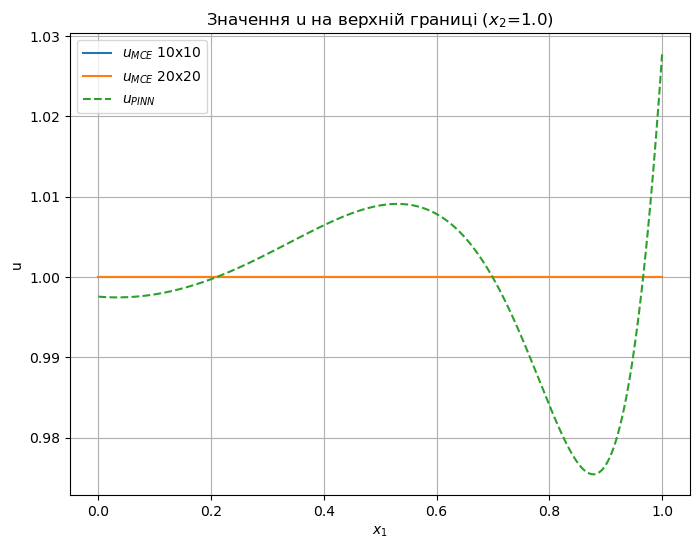

In [31]:
top_index = -1
top_boundary_fem_values_10 = u_fem_10[top_index, :]
top_boundary_fem_values_20 = u_fem_20[top_index, :]
#top_boundary_fem_values_50 = u_fem_50[top_index, :]
top_boundary_pinn_values = u_pinn[top_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x1_positions, top_boundary_fem_values_10, label='$u_{МСЕ}$ 10x10')
plt.plot(x1_positions, top_boundary_fem_values_20, label='$u_{МСЕ}$ 20x20')
#plt.plot(x1_positions, top_boundary_fem_values_50, label='$u_{МСЕ}$ 50x50')
plt.plot(x1_positions, top_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.xlabel('$x_1$')
plt.ylabel('u')
plt.title(f'Значення u на верхній границі ($x_2$={x2_positions[top_index]})')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
indices = np.linspace(0, N_of_test_points_2D - 1, 11, dtype=int)

data_right = {
    "x_2": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "МСЕ 10x10": right_boundary_fem_values_10[indices],
    "МСЕ 20x20": right_boundary_fem_values_20[indices],
    #"МСЕ 50x50": right_boundary_fem_values_50[indices],
    "PINN": right_boundary_pinn_values[indices],
    "du_PINN/dn": du_dn_right_boundary[indices]
}

df_right = pd.DataFrame(data_right).round(3)
print(f"Значення u на правій границі (x_1={x1_positions[right_index]}):")
print(df_right)

data_left = {
    "x_2": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "МСЕ 10x10": left_boundary_fem_values_10[indices],
    "МСЕ 20x20": left_boundary_fem_values_20[indices],
    #"МСЕ 50x50": left_boundary_fem_values_50[indices],
    "PINN": left_boundary_pinn_values[indices],
    "du_PINN/dn": du_dn_left_boundary[indices]
}

df_left = pd.DataFrame(data_left).round(3)
print(f"Значення u на лівій границі (x_1={x1_positions[left_index]}):")
print(df_left)


Значення u на правій границі (x_1=1.0):
      x_2  МСЕ 10x10  МСЕ 20x20   PINN  du_PINN/dn
0   0.000      0.000      0.000  0.002      -0.001
1   0.099      0.167      0.168  0.170       0.170
2   0.199      0.332      0.334  0.335       0.336
3   0.299      0.490      0.493  0.494       0.494
4   0.399      0.639      0.642  0.642       0.639
5   0.499      0.773      0.777  0.776       0.770
6   0.600      0.889      0.895  0.892       0.884
7   0.700      0.983      0.989  0.985       0.980
8   0.800      1.045      1.053  1.049       1.046
9   0.900      1.062      1.073  1.071       1.068
10  1.000      1.000      1.000  1.028       1.009
Значення u на лівій границі (x_1=0.0):
      x_2  МСЕ 10x10  МСЕ 20x20   PINN  du_PINN/dn
0   0.000      0.000      0.000  0.001      -0.001
1   0.099      0.107      0.107  0.108       0.000
2   0.199      0.214      0.214  0.215       0.001
3   0.299      0.320      0.320  0.320       0.002
4   0.399      0.424      0.424  0.424       0.003
5  

In [33]:
data_top = {
    "x_1": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "МСЕ 10x10": top_boundary_fem_values_10[indices],
    "МСЕ 20x20": top_boundary_fem_values_20[indices],
    #"МСЕ 50x50": top_boundary_fem_values_50[indices],
    "PINN": top_boundary_pinn_values[indices]
}

df_top = pd.DataFrame(data_top).round(3)
print(f"Значення u на верхній границі (x_2={x2_positions[top_index]}):")
print(df_top)

data_bottom = {
    "x_1": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "МСЕ 10x10": bottom_boundary_fem_values_10[indices],
    "МСЕ 20x20": bottom_boundary_fem_values_20[indices],
    #"МСЕ 50x50": bottom_boundary_fem_values_50[indices],
    "PINN": bottom_boundary_pinn_values[indices]
}

df_bottom = pd.DataFrame(data_bottom).round(3)
print(f"Значення u на нижній границі (x_2={x2_positions[bottom_index]}):")
print(df_bottom)

Значення u на верхній границі (x_2=1.0):
      x_1  МСЕ 10x10  МСЕ 20x20   PINN
0   0.000        1.0        1.0  0.998
1   0.099        1.0        1.0  0.998
2   0.199        1.0        1.0  1.000
3   0.299        1.0        1.0  1.003
4   0.399        1.0        1.0  1.006
5   0.499        1.0        1.0  1.009
6   0.600        1.0        1.0  1.008
7   0.700        1.0        1.0  1.000
8   0.800        1.0        1.0  0.984
9   0.900        1.0        1.0  0.977
10  1.000        1.0        1.0  1.028
Значення u на нижній границі (x_2=0.0):
      x_1  МСЕ 10x10  МСЕ 20x20   PINN
0   0.000        0.0        0.0  0.001
1   0.099        0.0        0.0  0.001
2   0.199        0.0        0.0  0.001
3   0.299        0.0        0.0  0.001
4   0.399        0.0        0.0  0.001
5   0.499        0.0        0.0  0.001
6   0.600        0.0        0.0  0.001
7   0.700        0.0        0.0  0.002
8   0.800        0.0        0.0  0.002
9   0.900        0.0        0.0  0.002
10  1.000        0.0  

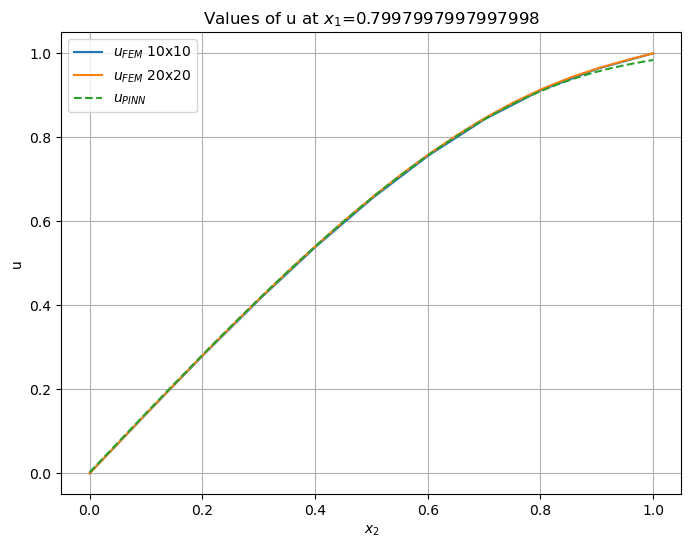

In [34]:
right_offset_index = int((0.8 - L_x1) / ((R_x1 - L_x1) / (N_of_test_points_2D - 1)))
right_offset_boundary_fem_values_10 = u_fem_10[:, right_offset_index]
right_offset_boundary_fem_values_20 = u_fem_20[:, right_offset_index]
#right_offset_boundary_fem_values_50 = u_fem_50[:, right_offset_index]
right_offset_boundary_pinn_values = u_pinn[:, right_offset_index]

plt.figure(figsize=(8, 6))
plt.plot(x2_positions, right_offset_boundary_fem_values_10, label='$u_{FEM}$ 10x10')
plt.plot(x2_positions, right_offset_boundary_fem_values_20, label='$u_{FEM}$ 20x20')
#plt.plot(x2_positions, right_offset_boundary_fem_values_50, label='$u_{FEM}$ 50x50')
plt.plot(x2_positions, right_offset_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.xlabel('$x_2$')
plt.ylabel('u')
plt.title(f'Values of u at $x_1$={x1_positions[right_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

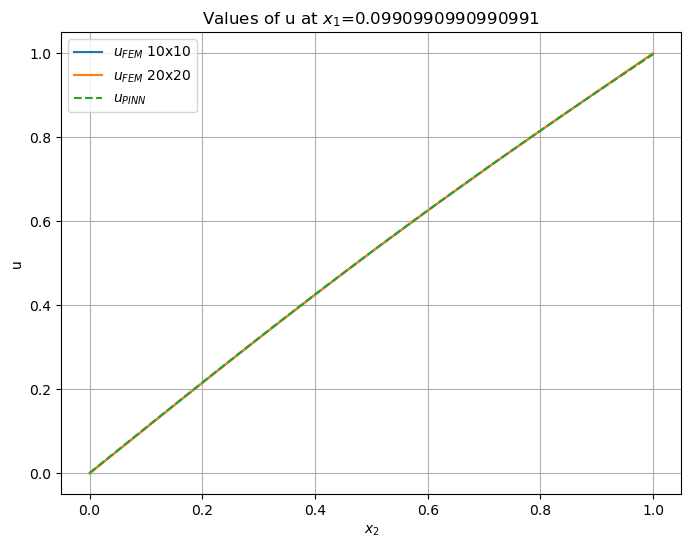

In [35]:
left_offset_index = int((0.1 - L_x1) / ((R_x1 - L_x1) / (N_of_test_points_2D - 1)))
left_offset_boundary_fem_values_10 = u_fem_10[:, left_offset_index]
left_offset_boundary_fem_values_20 = u_fem_20[:, left_offset_index]
#left_offset_boundary_fem_values_50 = u_fem_50[:, left_offset_index]
left_offset_boundary_pinn_values = u_pinn[:, left_offset_index]

plt.figure(figsize=(8, 6))
plt.plot(x2_positions, left_offset_boundary_fem_values_10, label='$u_{FEM}$ 10x10')
plt.plot(x2_positions, left_offset_boundary_fem_values_20, label='$u_{FEM}$ 20x20')
#plt.plot(x2_positions, left_offset_boundary_fem_values_50, label='$u_{FEM}$ 50x50')
plt.plot(x2_positions, left_offset_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.xlabel('$x_2$')
plt.ylabel('u')
plt.title(f'Values of u at $x_1$={x1_positions[left_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

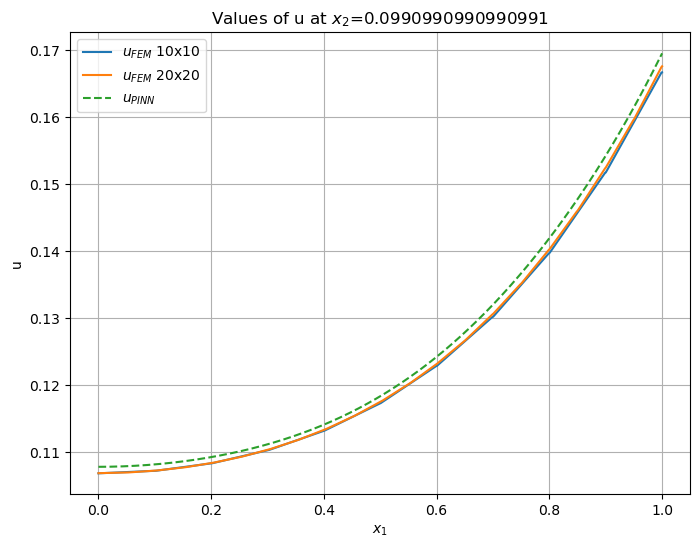

In [36]:
bottom_offset_index = int((0.1 - L_x2) / ((R_x2 - L_x2) / (N_of_test_points_2D - 1)))
bottom_offset_boundary_fem_values_10 = u_fem_10[bottom_offset_index, :]
bottom_offset_boundary_fem_values_20 = u_fem_20[bottom_offset_index, :]
#bottom_offset_boundary_fem_values_50 = u_fem_50[bottom_offset_index, :]
bottom_offset_boundary_pinn_values = u_pinn[bottom_offset_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x1_positions, bottom_offset_boundary_fem_values_10, label='$u_{FEM}$ 10x10')
plt.plot(x1_positions, bottom_offset_boundary_fem_values_20, label='$u_{FEM}$ 20x20')
#plt.plot(x1_positions, bottom_offset_boundary_fem_values_50, label='$u_{FEM}$ 50x50')
plt.plot(x1_positions, bottom_offset_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.xlabel('$x_1$')
plt.ylabel('u')
plt.title(f'Values of u at $x_2$={x2_positions[bottom_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

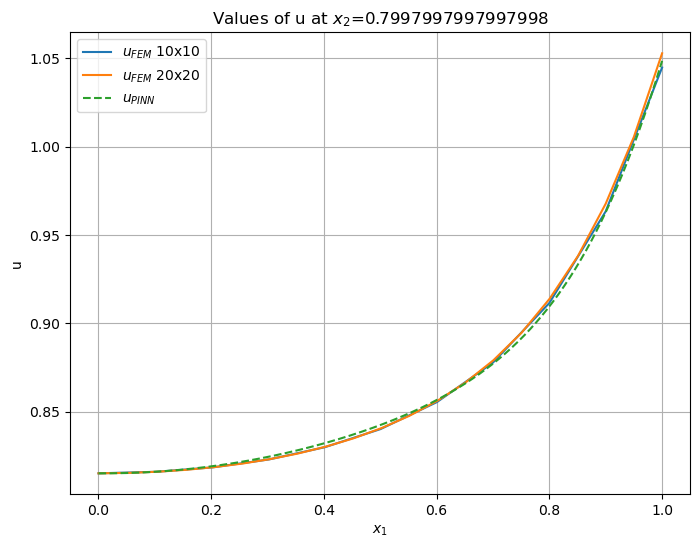

In [37]:
top_offset_index = int((0.8 - L_x2) / ((R_x2 - L_x2) / (N_of_test_points_2D - 1)))
top_offset_boundary_fem_values_10 = u_fem_10[top_offset_index, :]
top_offset_boundary_fem_values_20 = u_fem_20[top_offset_index, :]
#top_offset_boundary_fem_values_50 = u_fem_50[top_offset_index, :]
top_offset_boundary_pinn_values = u_pinn[top_offset_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x1_positions, top_offset_boundary_fem_values_10, label='$u_{FEM}$ 10x10')
plt.plot(x1_positions, top_offset_boundary_fem_values_20, label='$u_{FEM}$ 20x20')
#plt.plot(x1_positions, top_offset_boundary_fem_values_50, label='$u_{FEM}$ 50x50')
plt.plot(x1_positions, top_offset_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.xlabel('$x_1$')
plt.ylabel('u')
plt.title(f'Values of u at $x_2$={x2_positions[top_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
indices = np.linspace(0, N_of_test_points_2D - 1, 11, dtype=int)

data_right_offset = {
    "x_2": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "FEM 10x10": right_offset_boundary_fem_values_10[indices],
    "FEM 20x20": right_offset_boundary_fem_values_20[indices],
    #"FEM 50x50": right_offset_boundary_fem_values_50[indices],
    "PINN": right_offset_boundary_pinn_values[indices]
}

df_right_offset = pd.DataFrame(data_right_offset).round(3)
print(f"Values at x_1={x1_positions[right_offset_index]}:")
print(df_right_offset)

data_left_offset = {
    "x_2": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "FEM 10x10": left_offset_boundary_fem_values_10[indices],
    "FEM 20x20": left_offset_boundary_fem_values_20[indices],
    #"FEM 50x50": left_offset_boundary_fem_values_50[indices],
    "PINN": left_offset_boundary_pinn_values[indices]
}

df_left_offset = pd.DataFrame(data_left_offset).round(3)
print(f"Values at x_1={x1_positions[left_offset_index]}:")
print(df_left_offset)


Values at x_1=0.7997997997997998:
      x_2  FEM 10x10  FEM 20x20   PINN
0   0.000      0.000      0.000  0.002
1   0.099      0.140      0.140  0.142
2   0.199      0.278      0.279  0.280
3   0.299      0.412      0.413  0.414
4   0.399      0.537      0.539  0.539
5   0.499      0.653      0.655  0.654
6   0.600      0.755      0.758  0.756
7   0.700      0.842      0.845  0.842
8   0.800      0.912      0.914  0.910
9   0.900      0.963      0.964  0.956
10  1.000      1.000      1.000  0.984
Values at x_1=0.0990990990990991:
      x_2  FEM 10x10  FEM 20x20   PINN
0   0.000      0.000      0.000  0.001
1   0.099      0.107      0.107  0.108
2   0.199      0.215      0.215  0.215
3   0.299      0.321      0.321  0.321
4   0.399      0.425      0.425  0.425
5   0.499      0.526      0.527  0.527
6   0.600      0.625      0.625  0.626
7   0.700      0.722      0.722  0.722
8   0.800      0.816      0.816  0.816
9   0.900      0.908      0.908  0.908
10  1.000      1.000      1.000  0.

In [39]:
data_top_offset = {
    "x_1": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "FEM 10x10": top_offset_boundary_fem_values_10[indices],
    "FEM 20x20": top_offset_boundary_fem_values_20[indices],
    #"FEM 50x50": top_offset_boundary_fem_values_50[indices],
    "PINN": top_offset_boundary_pinn_values[indices]
}

df_top_offset = pd.DataFrame(data_top_offset).round(3)
print(f"Values at x_2={x2_positions[top_offset_index]}:")
print(df_top_offset)

data_bottom_offset = {
    "x_1": np.linspace(L_x1, R_x1, N_of_test_points_2D)[indices],
    "FEM 10x10": bottom_offset_boundary_fem_values_10[indices],
    "FEM 20x20": bottom_offset_boundary_fem_values_20[indices],
    #"FEM 50x50": bottom_offset_boundary_fem_values_50[indices],
    "PINN": bottom_offset_boundary_pinn_values[indices]
}

df_bottom_offset = pd.DataFrame(data_bottom).round(3)
print(f"Values at x_2={x2_positions[bottom_offset_index]}:")
print(df_bottom_offset)

Values at x_2=0.7997997997997998:
      x_1  FEM 10x10  FEM 20x20   PINN
0   0.000      0.815      0.815  0.815
1   0.099      0.816      0.816  0.816
2   0.199      0.818      0.818  0.819
3   0.299      0.823      0.823  0.824
4   0.399      0.830      0.830  0.832
5   0.499      0.840      0.840  0.842
6   0.600      0.855      0.856  0.857
7   0.700      0.878      0.879  0.877
8   0.800      0.912      0.914  0.910
9   0.900      0.963      0.968  0.963
10  1.000      1.045      1.053  1.049
Values at x_2=0.0990990990990991:
      x_1  МСЕ 10x10  МСЕ 20x20   PINN
0   0.000        0.0        0.0  0.001
1   0.099        0.0        0.0  0.001
2   0.199        0.0        0.0  0.001
3   0.299        0.0        0.0  0.001
4   0.399        0.0        0.0  0.001
5   0.499        0.0        0.0  0.001
6   0.600        0.0        0.0  0.001
7   0.700        0.0        0.0  0.002
8   0.800        0.0        0.0  0.002
9   0.900        0.0        0.0  0.002
10  1.000        0.0        0.0  0.

In [40]:
from docx import Document

doc = Document()
def addTable(df, text):
    doc.add_paragraph(text)
    table = doc.add_table(rows=1, cols=len(df.columns))

    table.style = 'Table Grid'

    hdr_cells = table.rows[0].cells
    for i, col_name in enumerate(df.columns):
        hdr_cells[i].text = col_name

    for index, row in df.iterrows():
        row_cells = table.add_row().cells
        for i, value in enumerate(row):
            row_cells[i].text = str(value)

    

addTable(df_right, "Right")
addTable(df_left, "Left")
addTable(df_bottom, "Bottom")
addTable(df_top, "Top")

doc.save('/mnt/c/output_table.docx')
